In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")


In [2]:
def find_nth(haystack, needle, n):
        start = haystack.find(needle)
        while start >= 0 and n > 1:
            start = haystack.find(needle, start+len(needle))
            n -= 1
        return start


def flatEqnOfEval(eval):
        idx_2nd_equals = find_nth(eval,'=',2)
        eqn_flat = eval[:idx_2nd_equals].replace(' ','')
        return eqn_flat


In [3]:
def getAccuracy(completion_evals, expected_completion_evals, eval_dict):

    spaced_eval_dict = eval_dict
    spaced_keys = spaced_eval_dict.keys()

    eval_dict = {}
    for key in spaced_keys:
        eval_dict[key.replace(' ', '')] = spaced_eval_dict[key]

    def LHSOfEqn(eqn_str):
        first_equals = eqn_str.find('=')
        LHS = eqn_str[0:first_equals].replace(' ', '')
        return LHS

    def RHSOfEqn(eqn_str):
        last_equals = eqn_str.rfind('=')
        RHS = eqn_str[last_equals+1:].replace(' ', '')
        return RHS

    '''
    metric = value | verbatim
    accuracyType = numCorrectOverTotal | firstIncorrectOverTotal

    ((accuracy[type])[metric]) = a number

    accuracy = {
        numCorrectAcc: {
            value: ...,
            verbatim: ...,
        },
        firstIncorrectAcc: {
            value: ...,
            verbatim: ...,
        }
    }
    '''
    numCorrectAcc = {"value": 0, "verbatim": 0,"equation":0}
    firstIncorrectAcc = {"value": 1, "verbatim": 1,"equation": 1}
    _firstIncorrectValNotFound = True
    _firstIncorrectVerbNotFound = True
    _firstIncorrectEqnNotFound = True


    ############################################################################################### this is messy; can refactor
    expectedFlatEqns=[]
    num_expected_eqns = len(expected_completion_evals)
    for i in range(num_expected_eqns):
        expected_eval = expected_completion_evals[i]

        expectedFlatEqns.append(flatEqnOfEval(expected_eval))

    def looseIn(needle,haystack):
        for hay in haystack:
            if needle in hay:
                return True
        return False
    ###############################################################################################

    num_expected_eqns = len(expected_completion_evals)
    for i in range(num_expected_eqns):
        expected_eval = expected_completion_evals[i]


        # get completed equation
        try:
            completion_eval = completion_evals[i]
        except:
            completion_eval = ''

        completion_LHS, completion_RHS = LHSOfEqn(
            completion_eval), RHSOfEqn(completion_eval)

        
        # check if completed eqn equal to actual, using various metrics
        try:
            equal_verbatim = (completion_eval == expected_eval)
        except:
            equal_verbatim = False

        try:
            equal_value = (eval_dict[completion_LHS]
                           == int(completion_RHS[-2:]))
        except:
            equal_value = False

        try:
            equal_eqn = looseIn(flatEqnOfEval(completion_eval) , expectedFlatEqns)
        except:
            equal_eqn = False

        #compute the accuracy per equation with each metric
        numCorrectAcc["value"] += int(equal_value) / num_expected_eqns
        numCorrectAcc["verbatim"] += int(equal_verbatim) / num_expected_eqns
        numCorrectAcc["equation"] += int(equal_eqn) / num_expected_eqns

        if (not equal_value) and _firstIncorrectValNotFound:
            firstIncorrectAcc["value"] = i / num_expected_eqns
            _firstIncorrectValNotFound = False
        if (not equal_verbatim) and _firstIncorrectVerbNotFound:
            firstIncorrectAcc["verbatim"] = i / num_expected_eqns
            _firstIncorrectVerbNotFound = False
        if (not equal_eqn) and _firstIncorrectEqnNotFound:
            firstIncorrectAcc["equation"] = i / num_expected_eqns
            _firstIncorrectEqnNotFound = False

    accuracy = {
        "numCorrectAcc": numCorrectAcc,
        "firstIncorrectAcc": firstIncorrectAcc,
    }

    return accuracy


def averageOfAccuracies(accs):
    acc_avg = {
        "numCorrectAcc": {
            "value": 0,
            "verbatim": 0,
            "equation": 0,
        },
        "firstIncorrectAcc": {
            "value": 0,
            'verbatim': 0,
            "equation": 0,
        }
    }

    for acc in accs:
        for _type in acc.keys():
            for _metric in acc[_type].keys():
                acc_avg[_type][_metric] += acc[_type][_metric] / len(accs)

    return acc_avg


def strToEqns(text):
    _completion_lines = text.split('\n')
    _completion_lines = [eqn.replace('\n', '') for eqn in _completion_lines]
    _eqn_idxs = [i for i, completion_line in enumerate(
        _completion_lines) if '=' in completion_line]
    eqns = [_completion_lines[eqn_idx] for eqn_idx in _eqn_idxs]
    return eqns


In [4]:
def getExperimentAccs(experiments,experiments_config):
    _ACCS_OF_HINTLEN = {}  # HINTLEN_VS_ACC[len] = list of accuracies
    _EXPECTED_ACC_OF_HINTLEN = {}

    num_experiments = len(experiments)
    for i_expt in range(num_experiments):

        trials = experiments[i_expt]
        config = experiments_config[i_expt]

        HINTLEN = int(config.NUM_NAME_HINTS)
        _ACCS_OF_HINTLEN[HINTLEN] = []
        _EXPECTED_ACC_OF_HINTLEN[HINTLEN] = max(float((config.NUM_NAME_HINTS - config.NUM_EQN_HINTS) / (
            config.NUM_VARS-config.NUM_EQN_HINTS)), 0)  # acc if hint correct and rest incorrect

        num_trials = len(trials)
        for i_trial in range(num_trials):
            trial = trials.iloc[i_trial]

            completion_text = trial.completion
            expected_completion_text = trial.expected_completion
            eval_dict = trial.eval_dict

            completion_eqns = strToEqns(completion_text)
            expected_completion_eqns = strToEqns(expected_completion_text)

            _ACC = getAccuracy(completion_eqns, expected_completion_eqns, eval_dict)

            _ACCS_OF_HINTLEN[HINTLEN].append(_ACC)

    return _ACCS_OF_HINTLEN,_EXPECTED_ACC_OF_HINTLEN
    

In [5]:
experiments = []
experiments_config = []

for hint_len in range(0, 16+1, 2):
    experiments.append(pd.read_json(
        rf'data/[5]{hint_len}_hints,16_var,model_text-davinci-002.json', orient='records'))
    experiments_config.append(pd.read_json(
        rf'data/[config][5]{hint_len}_hints,16_var,model_text-davinci-002.json', orient='records'))


In [6]:
accOfLen, expectedAccOfLen = getExperimentAccs(experiments,experiments_config)

avgAccOfLen = {}  # accuracy of hint length averaged over all trials
for hintlen in accOfLen.keys():
    avgAccOfLen[hintlen] = averageOfAccuracies(accOfLen[hintlen])

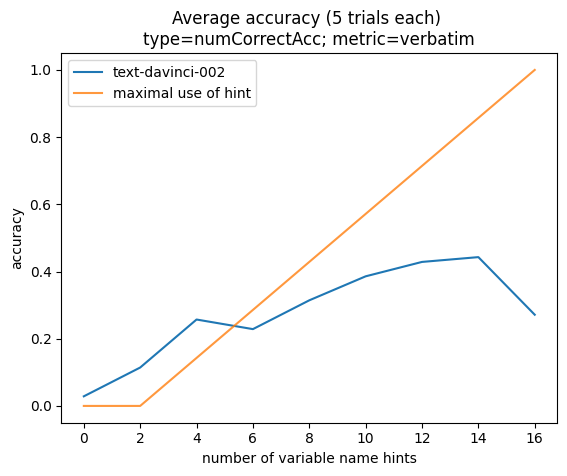

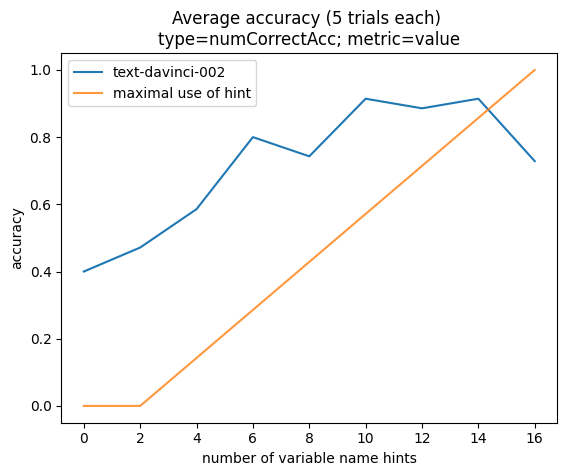

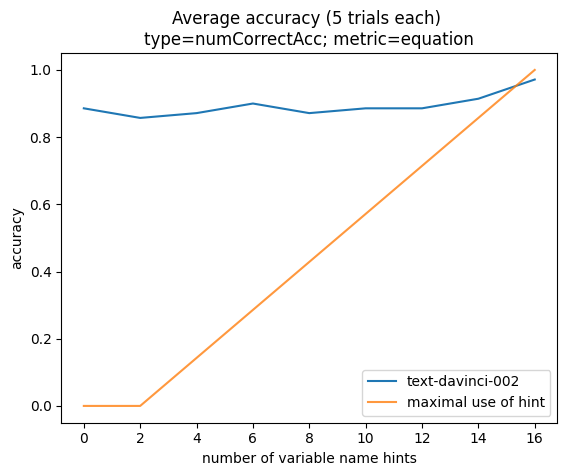

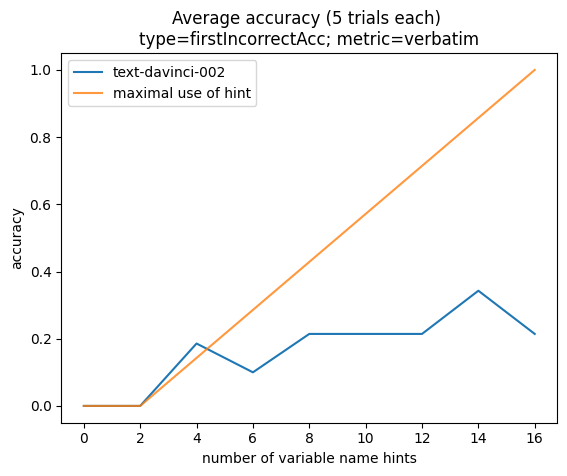

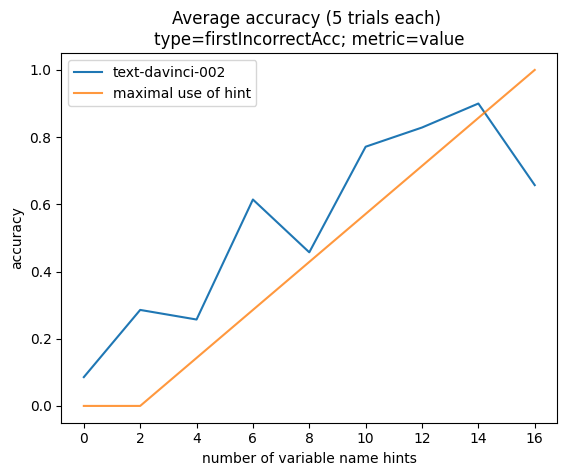

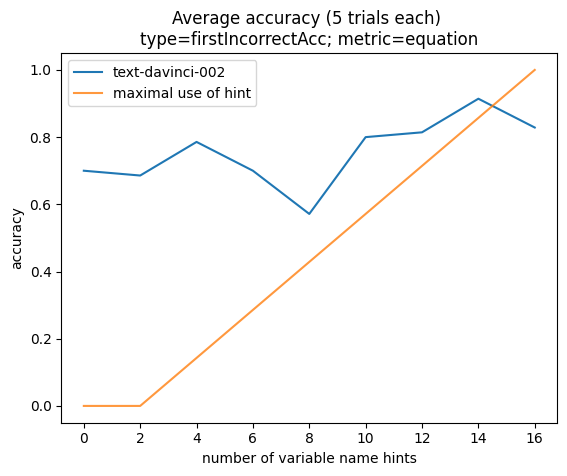

In [7]:
ACC_TYPES =  ['numCorrectAcc', 'firstIncorrectAcc']
ACC_METRICS = ['verbatim','value','equation']  # 'verbatim' | 'value' | 'equation' (is the copied thing verbatim correct, or does it have the right corresponding value for the variable on LHS, or is the copied equation right)


for acc_type in ACC_TYPES:
    for acc_metric in ACC_METRICS:
        xs = avgAccOfLen.keys()
        ys = [avgAccOfLen[key][acc_type][acc_metric] for key in avgAccOfLen.keys()]
        plt.plot(xs,ys, label='text-davinci-002')

        ys_expected = expectedAccOfLen.values()
        plt.plot(xs,ys_expected,label='maximal use of hint',alpha=.8)


        plt.xlabel('number of variable name hints')
        plt.ylabel('accuracy')
        plt.title(f'Average accuracy (5 trials each) \ntype={acc_type}; metric={acc_metric}')
        plt.legend()
        plt.show()

In [8]:
num_experiments = len(experiments)
for i_expt in range(num_experiments):
    trials = experiments[i_expt]
    config = experiments_config[i_expt]

    num_trials = len(trials)
    for i_trial in range(num_trials):
        trial = trials.iloc[i_trial]

        prompt = trial.prompt
        completion_text = trial.completion
        expected_completion_text = trial.expected_completion
        eval_dict = trial.eval_dict


        print('************************************************************************')
        print(prompt+'[START]'+completion_text)

************************************************************************
ever since the 1500s when = -was
publishing software = -leap into
has = +printing and typesetting industry
galley of = -Ipsum
Ipsum = -publishing software
in the 1960s with = -to make
to make = -galley of
text of = +in the 1960s with
was = -text of
printing and typesetting industry = -ever since the 1500s when
leap into = +1
sheets containing = +has
electronic typesetting remaining essentially unchanged It = +sheets containing
an unknown printer took = +electronic typesetting remaining essentially unchanged It
type specimen = +an unknown printer took
the = +type specimen

Evaluating all the variables :
leap into = +1
publishing software = -leap into = -(+1) = -1
[START]has = +printing and typesetting industry
galley of = -Ipsum
Ipsum = -publishing software = -(-1) = 1
in the 1960s with = -to make
to make = -galley of = -(1) = -1
text of = +in the 1960s with = +(-1) = -1
was = -text of = -(-1) = 1
printing and type

In [9]:
num_experiments = len(experiments)
for i_expt in range(num_experiments):
    trials = experiments[i_expt]
    config = experiments_config[i_expt]

    num_trials = len(trials)
    for i_trial in range(num_trials):
        trial = trials.iloc[i_trial]

        prompt = trial.prompt
        completion_text = trial.completion
        expected_completion_text = trial.expected_completion
        eval_dict = trial.eval_dict


        print('************************************************************************')
        print(eval_dict)

************************************************************************
{'leap into': 1, 'publishing software': -1, 'Ipsum': 1, 'galley of': -1, 'to make': 1, 'in the 1960s with': -1, 'text of': -1, 'was': 1, 'ever since the 1500s when': -1, 'printing and typesetting industry': 1, 'has': 1, 'sheets containing': 1, 'electronic typesetting remaining essentially unchanged It': 1, 'an unknown printer took': 1, 'type specimen': 1, 'the': 1}
************************************************************************
{'has': 1, 'Lorem': 1, 'type specimen': 1, 'recently with': -1, 'an unknown printer took': -1, 'like Aldus PageMaker including versions': -1, 'the': 1, 'Ipsum': -1, 'ever since the 1500s when': -1, 'was': 1, 'survived not only': -1, 'publishing software': 1, 'release': 1, 'dummy': -1, 'of Letraset': -1}
************************************************************************
{'an unknown printer took': 1, 'a': 1, 'Ipsum': 1, 'survived not only': -1, 'book It': 1, 'has': 1, 'dummy':

In [10]:
num_experiments = len(experiments)
for i_expt in range(num_experiments):
    trials = experiments[i_expt]
    config = experiments_config[i_expt]

    num_trials = len(trials)
    for i_trial in range(num_trials):
        trial = trials.iloc[i_trial]

        prompt = trial.prompt
        completion_text = trial.completion
        expected_completion_text = trial.expected_completion
        eval_dict = trial.eval_dict


        completion_eqns = strToEqns(completion_text)
        expected_completion_eqns = strToEqns(expected_completion_text)

        acc = getAccuracy(completion_eqns, expected_completion_eqns, eval_dict)

        if acc['numCorrectAcc']['value'] > .95:
            print('************************************************************************')
            print(prompt+'[START]'+completion_text)




************************************************************************
ever since the 1500s when = -was
publishing software = -leap into
has = +printing and typesetting industry
galley of = -Ipsum
Ipsum = -publishing software
in the 1960s with = -to make
to make = -galley of
text of = +in the 1960s with
was = -text of
printing and typesetting industry = -ever since the 1500s when
leap into = +1
sheets containing = +has
electronic typesetting remaining essentially unchanged It = +sheets containing
an unknown printer took = +electronic typesetting remaining essentially unchanged It
type specimen = +an unknown printer took
the = +type specimen

Evaluating all the variables leap into,publishing software,...:
leap into = +1
publishing software = -leap into = -(+1) = -1
[START]has = +printing and typesetting industry = +(+1) = +1
galley of = -Ipsum = -(+1) = -1
Ipsum = -publishing software = -(-1) = +1
in the 1960s with = -to make = -(+1) = -1
to make = -galley of = -(-1) = +1
text of = +i